# Introduction

One very hot area in the current field of data science is forecasting housing and real-estate prices. The real-estate company Zillow recently made headlines when they announced that they were discontinuing their “iBuying” feature as they were rapidly losing money due to a failure to accurately estimate house prices using algorithms. In general, financial data modeling and financial forecasting is extremely difficult (bordering on “impossible”), and real-estate forecasting has many similar problems. 

In light of this, it seemed obvious that a housing dataset would make a good choice for the assignment as most people interact with the real estate market over their lifetimes and the usual features of housing datasets (geographic features, physical features, etc.) are quite fun to play around with. Consequently, a suitable housing dataset was found and used as the basis for the assignment. 


# Methodology

## Data and Data Cleaning

The dataset of interest came from kaggle.com and concerned housing data from the city of Melbourne, Australia in the years 2017 and 2018 (https://www.kaggle.com/anthonypino/melbourne-housing-market?select=Melbourne_housing_FULL.csv). The Kaggle dataset did not originally have a data dictionary and documentation was very sparse in general, but a data dictionary was found on a third-party GitHub repository (https://github.com/njtierney/melb-housing-data), which helped shed light on some of the data attributes.  The base dataset had 34,857 rows and 21 columns. 

Cleaning the data was a multi-step process. To start with, all rows that did not have pricing information were dropped.  A number of columns were also dropped. This was because these were irrelevant or hard to work with (such as the name of the seller or the date sold) or because the number of unique values was prohibitively large (such as the list of unique addresses). In total, 9 features were dropped in this manner. 

One tricky thing to consider was the question of area (how large the property is), which was expected to correlate highly with price. In the base dataset there were two features meant to estimate this (“Landsize” and “BuildingArea”), but neither feature appeared in the data dictionary, both had very large numbers of missing values (about 9,200 for Landsize and about 16,600 for BuildingArea), and for cases where neither value was missing one value was not consistently larger than the other. While definitely dirty and lacking in documentation, early exploration showed that both variables had a Pearson’s correlation of more than 0.4 with price, meaning that they were too valuable to simply discard. 

To reconcile this, a new feature, “Area”, was engineered which was equal to the average of Landsize and BuildingArea (for cases where both values existed) or just whichever value was present (if only one value was present for a given datapoint). “Area” was then taken to the 4th root to ensure a sufficiently smooth distribution between 0 and 1 during the normalization phase of the data cleaning process. 

To finish cleaning the dataset, two outliers for “Price” and “YearBuilt” were excluded and almost all features were scaled to be in the range of 0 to 1 with missing values indicated as -1. The two remaining nominal variables (“Type” and “RegionName”) were converted to a one hot encoding scheme. The final, cleaned dataset consisted of 27,245 rows and 11 features (21 features after one hot encoding). The final list of features in the cleaned dataset and how they were processed can be seen in Table 1. 



## Table of Features in Cleaned Dataset


| Column | Definition | Handling
| --- | --- | --- |
| Rooms | The number of bedrooms in the property | Normalized |
| Type | The property type (house, townhouse, or unit) | One Hot Encoded|
| Price | The sale price in Australian Dollars. Also the label variable to be predicted | Unaltered, rows with missing values dropped |
| Distance | The property's distance from the Melbourne Central Business District (in km) | Normalized |
| Bathroom | The number of bathrooms | Normalized |
| Car | The number of carspots for the property | Normalized |
| Area | An engineered feature representing the "size" of the property | Engineered, taken to the 4th root  |
| YearBuilt |The year the property was built| Normalized |
| Lattitude | The latititude of the property |Normalized |
| Longtitude | The longitude of the property | Normalized|
| Regionname | The name of the city region the property exists in | One Hot Encoded |

<br>
<center><b>Table 1:</b> List of features in the cleaned dataset </center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc

from sklearn.metrics import mean_absolute_error

from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.random import set_seed

In [2]:
# helper functions. 

def normalize(df, list_of_cols): 
    """Helper function that normalizes the given columns for a df. Returns the new df."""
    for col in list_of_cols:
        df[col] = (df[col] - np.nanmin(df[col]))/(np.nanmax(df[col]) - np.nanmin(df[col]))
        
        
    return(df)


def split_into_validate(data_array, labels_array, validation_proportion): 
    """Helper function that split train_x and train_y into train and validate x and y"""

    
    # Getting train and validation indices. Validation indices are randomly selected from overall. Train indices are
    # just whichever indices where not chosen as validation indices
    overall_indices = range(len(data_array))
    
    val_indices = np.random.choice(a = overall_indices, size = int(len(data_array) * validation_proportion), 
                                    replace = False) 
    
    # Training inidices are the set of overall indices after we take out the validation indices
    train_indices = list(set(overall_indices).difference(val_indices))
    
    # train data partition
    train_X = data_array[train_indices]
    train_Y = labels_array[train_indices]
        
    # validation data partition
    val_X = data_array[val_indices]
    val_Y = labels_array[val_indices]
    
    return(train_X, train_Y, val_X, val_Y)

In [3]:
# Setting seeds for replication. 
seed_val = 19

np.random.seed(seed_val)
set_seed(seed_val)

In [4]:
# Reading in the base df
base_df = pd.read_csv("Melbourne_housing_FULL.csv")

# Drop all rows where we don't have price data. 
cleaned_df = base_df[base_df["Price"].notna()]

# Get rid of the annyoing warning messages for slice assignment. 
pd.options.mode.chained_assignment = None  # default='warn'

# Drop some columns. Either too many unique values or just generally irrelvent. 
drop_cols = ["Suburb", "Address", "Method", "SellerG", "Date",  "Postcode", "Bedroom2", 
             "Propertycount", "CouncilArea"]
cleaned_df.drop(axis = 1, columns=drop_cols, inplace=True)

# Build a new measure, "Area", from the two really dirty columns. 
temp_matrix = cleaned_df[["Landsize", "BuildingArea"]].values
cleaned_df["Area"] = np.nanmean(temp_matrix, axis = 1)

# Area has an extremely long tail. Take the 4th root to compress the range of value and
# prevent bunching. 
cleaned_df["Area"] = np.sqrt(np.sqrt(cleaned_df["Area"])) 

# No longer needed. 
del temp_matrix         

# Drop the no longer needed columns relating to area. 
drop_cols = ["Landsize", "BuildingArea"]
cleaned_df.drop(axis = 1, columns=drop_cols, inplace=True)

# rename one of the columns. 
cleaned_df.rename(columns ={"Regionname": "RegionName"}, inplace =True )

# Excluding a few outliers we noticed during exploration. We drop them from the dataset.
cleaned_df = cleaned_df[cleaned_df["Price"] != 11200000.0]
cleaned_df = cleaned_df[cleaned_df["YearBuilt"]!= 1196]


# For all these columns, range to [0 - 1]. Missing values will be indicated with -1. 
normalized_columns = ['Rooms', 'Distance', 'Bathroom', 'Car', 'YearBuilt', 'Lattitude', 'Longtitude', "Area"]
cleaned_df = normalize(cleaned_df, normalized_columns)


# For the entire dataframe, fill in NA values with -1 after normalization.
cleaned_df.fillna(value = -1, inplace = True)

# For all these, convert labels to OHE. 
cleaned_df = pd.get_dummies(data = cleaned_df, columns= ["Type", "RegionName"])


# Save cleaned dataframe to disk, just to be on the safe side. 
cleaned_df.to_csv("cleaned_melbourne.csv", header=True, index=False)

C:\Users\Jack\AppData\Local\Temp/ipykernel_35880/3317385550.py:17: RuntimeWarning: Mean of empty slice
  cleaned_df["Area"] = np.nanmean(temp_matrix, axis = 1)


In [5]:
# Going over everything to make sure our distributions are sensible after normalization. 
# This has been commented out to avoid cluttering things,


# for key in cleaned_df.keys(): 
    
#     arr = cleaned_df[key].unique()
#     print(key)
#     print("-----------")
#     try:
#         print(np.sort(arr))
#     except: 
#         print(arr)
#     plt.plot(np.sort(cleaned_df[key]))
#     plt.show()

In [6]:
# Shuffle the dataframe to prevent ordering bias. 
cleaned_df = cleaned_df.sample(frac=1).reset_index(drop=True)


# Taking our dataframe and extracting the relevant data as matrices. 
Y_dataset = cleaned_df["Price"].values
cleaned_df.drop(axis = 1, columns=["Price"], inplace=True)

X_dataset = cleaned_df.values

# 80/20 train test split
cutoff_value = int(0.8 * len(Y_dataset))

X_train = X_dataset[:cutoff_value]
X_test = X_dataset[cutoff_value:]

Y_train = Y_dataset[:cutoff_value]
Y_test = Y_dataset[cutoff_value:]

# Convert to numpy arrays. 
train_indices = np.array(range(len(X_train)))
test_indices = np.array(range(len(X_test)))

X_train = np.array(X_train)[train_indices.astype(int)]
X_test = np.array(X_test)[test_indices.astype(int)]
Y_train = np.array(Y_train)[train_indices.astype(int)]
Y_test = np.array(Y_test)[test_indices.astype(int)]


# No longer needed. 
del cutoff_value, X_dataset, Y_dataset

## Network Topologies and Training 

To estimate housing prices, three different networks were constructed. The first was simple network that could outperform a pre-selected baseline, the second was a high-capacity network that was deliberately meant to overfit, and the third was a final network that was an optimized and regularized version of the high-capacity network  For the baseline measure of success, the simple average of the housing prices in the training dataset was selected.   

For all of the layers in every network the only activations used were ReLU. The output in every network was a single neuron with relu activation, as the variable of interest for this assignment was house prices which are positive real numbers that range from 0 to several million, making ReLU a natural choice. 

For the loss metric, mean absolute error (MAE) was chosen. This was because the task was estimating asset prices, and in such a task financial loss and gain is completely fungible (i.e. losing 5,000 dollars twice is exactly as bad as losing 10,000 dollars once). Early experimentation also revealed that fitting was very bad with mean squared error, as the network became far too sensitive to outliers (i.e. the smaller number of extremely expensive properties). 

For the optimizer, the ADAM (adaptive moment estimation) optimizer was chosen, as it is a more advanced optimizer that builds on the work of previous optimizers such as AdaGrad and RMSProp by making use of both the first and second statistical moments for gradient updates. All parameters for the ADAM optimizer were kept constant at the default values with the exception of the learning rate, which was part of hyperparameter optimization for finding the final model

For hyperparameter optimization, the strategy employed was a simple grid search. The two hyperparameters considered were the batch size (8, 16, 32, or 64) and the learning rate (0.005, 0.001, 0.0005, or 0.0001). The number of epochs was kept constant at 200. The training and testing sets were a simple 80/20 split, meaning that each training set was 64% of the data, each validation set was 16% of the data, and the testing set was 20% of the data. 

For validation, simple hold-out validation was used where the the validation set was always 20% of the data in the training set, randomly chosen each time before training. The model's performance on the validation set was used to select the best hyperparameters for training the final mode, and performance on the validation and training sets was also used to identify the ideal number of training

After hyperparameter optimization, the best set of hyperparameters was fed into a final model consisting of two hidden layers of 32 neurons, dropout of 0.2, and relu activation. The final model was trained for 2,400 epochs to try and get the most ideal fit on the training data. 

### Baseline. 

The "baseline" model is simply the average of the house prices on the training dataset. 

In [7]:
train_preds = [np.nanmean(Y_train)] * len(Y_train)
test_preds = [np.nanmean(Y_train)] * len(Y_test)


print("MAE on training set if just taking the average: {}".format(mean_absolute_error(Y_train, train_preds)))
print("MAE on testing set if just taking the average: {}".format(mean_absolute_error(Y_test, test_preds)))
del train_preds, test_preds

MAE on training set if just taking the average: 449500.7725411852
MAE on testing set if just taking the average: 456321.5907042787


### Simple Model. 

A simple model that performs better than the baseline. The model consists of two hidden layers, each with 8 neurons. All activations are Relu. The model has a batch size of 32, a learning rate of 0.001, and is trained for 200 epochs. The model is able to beat the baseline score, as demonstrated below. 

In [ ]:
simp_network = models.Sequential()
simp_network.add(layers.Dense(8, activation='relu', input_shape=(20, )))
simp_network.add(layers.Dense(8, activation='relu', input_shape=(8, )))
simp_network.add(layers.Dense(1, activation='relu', input_shape= (8, )))

# optimiser, loss and metrics are chosen at compilation
simp_network.compile(optimizer=Adam(lr=0.001),
                loss='mean_absolute_error', 
                metrics=["mean_absolute_error"])


simp_network.fit(X_train, 
                Y_train, 
                epochs=200,                 # Run for 200 epochs. 
                batch_size = 32, 
                )

In [10]:
print("Train MAE: {}".format(mean_absolute_error(simp_network.predict(X_train), Y_train)))
print("Test MAE: {}".format(mean_absolute_error(simp_network.predict(X_test), Y_test)))

Train MAE: 280723.8074483635
Test MAE: 288779.00253262854


### Model  that overfits. 

A deliberately over-capacity model that performs better than the baseline. The model consists of five hidden layers, each with 32 neurons. All activations are Relu. The model has a batch size of 32, a learning rate of 0.001, and is trained for 3000 epochs. After extension experimentation, the point where overfitting happens is around epoch 2400.

In [ ]:
overfit_network = models.Sequential()
overfit_network.add(layers.Dense(32, activation='relu', input_shape=(20, )))
overfit_network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
overfit_network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
overfit_network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
overfit_network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
overfit_network.add(layers.Dense(1, activation='relu', input_shape= (32, )))

# optimiser
overfit_network.compile(optimizer=Adam(lr=0.001),
                loss='mean_absolute_error', 
                metrics=["mean_absolute_error"])


train_data, train_labels, val_data, val_labels = split_into_validate(X_train, Y_train, 0.2)


learning_history = overfit_network.fit(
                x = train_data, 
                y = train_labels, 
                epochs=3000,                 # Run for 3000 epochs. 
                batch_size = 32, 
                validation_data = (val_data, val_labels)
                )

# No longer needed past this point. 
del train_data, train_labels, val_data, val_labels

In [12]:
print("Train MAE: {}".format(mean_absolute_error(overfit_network.predict(X_train), Y_train)))
print("Test MAE: {}".format(mean_absolute_error(overfit_network.predict(X_test), Y_test)))

best_epoch = np.argmin(learning_history.history['val_loss'])

print("Best Epoch Number: {}".format(best_epoch))

Train MAE: 170737.4840122614
Test MAE: 193264.34697020095
Best Epoch Number: 2403


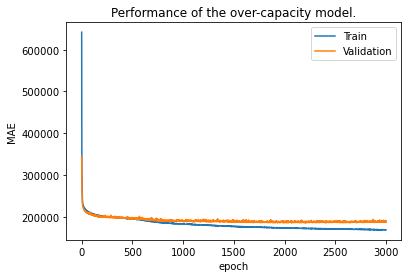

In [13]:
plt.plot(range(3000), learning_history.history['loss'], label = "Train")
plt.plot(range(3000), learning_history.history['val_loss'], label = "Validation")
plt.title('Performance of the over-capacity model.')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()
# plt.savefig("bias_variance.png")

<br>
<center><b>Figure 1:</b> Bias/Variance decomposition for the overfit network. </center>

### Final model

The final model that makes use of hyperparameter optimization and regularization. Based on the results from training the overfitting network, the model was trained for 2,400 epochs. The model consisted of two layers of 32 neurons with dropout of 0.2 on each layer. 

For hyperparameter optimization, A unique model was trained for each hyperparameter combination (16 overall) for 200 epochs each. The validation and training loss for each of those individual networks was then recorded and used to determine the best hyperparameters for training the final. 


#### Hyperparameter Optimization

In [ ]:
# Array to hold the train and validation scores for each combination. 
results_array = np.zeros(shape = (4, 4, 2))


for i, batch_size in enumerate([8, 16, 32, 64]):
    for j, learning_rate in enumerate([0.005, 0.001, 0.0005, 0.0001]):
        
        # Garbage collection for optimization reasons.
        gc.collect()
        
        # Deliberately over-capacity fully connected network. For the final network, these 512 layers will be replaced
        # with 32 neurons. 
        network = models.Sequential()
        network.add(layers.Dense(32, activation='relu', input_shape=(20, )))
        network.add(layers.Dropout(.2, input_shape=(32,)))
        network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
        network.add(layers.Dropout(.2, input_shape=(32,)))
        network.add(layers.Dense(1, activation='relu', input_shape= (32, )))

        # optimiser, loss and metrics are chosen at compilation
        network.compile(optimizer=Adam(lr=learning_rate),
                        loss='mean_absolute_error', 
                        metrics=["mean_absolute_error"])
        
        
        train_data, train_labels, val_data, val_labels = split_into_validate(X_train, Y_train, 0.2)
        
        learning_history = network.fit(
                x = train_data, 
                y = train_labels, 
                epochs=200,                 # Run for 200 epochs. 
                batch_size = 32, 
                validation_data = (val_data, val_labels)
                )
        
        

        results_array[i, j, 0] = np.min(learning_history.history["loss"])
        results_array[i, j, 1] = np.min(learning_history.history["val_loss"])
        
del train_data, train_labels, val_data, val_labels

best batch size indice: 1
best learning rate indice: 0


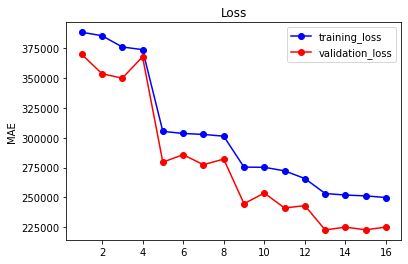

In [15]:
# Finding the best hyperparameters based on the validation performance. 
best = np.min(results_array[:, :, 1])
indices_of_best_validation = np.where(results_array[:, :, 1]==best)
        
print("best batch size indice: {}".format(indices_of_best_validation[0][0]))
print("best learning rate indice: {}".format(indices_of_best_validation[1][0]))


# Plotting df to hold our values 
plotting_df = pd.DataFrame({"validation": results_array[:, :, 1].flatten(), 
                            "training": results_array[:, :, 0].flatten()})

plotting_df.sort_values(by = "training", ascending=False, inplace=True)
plotting_df.reset_index(drop=True, inplace=True)

# Plot train and validation, by training descending
plt.plot(range(1, 17), plotting_df["training"], '-o', c = "blue", label = "training_loss")
plt.plot(range(1, 17), plotting_df["validation"], '-o', c = "red", label = "validation_loss")

plt.xlabel("")
plt.ylabel("MAE")
plt.title("Loss")
plt.legend()
plt.show()
# plt.savefig("train_and_val_plot.png")

# # no longer_needed
del plotting_df, best, indices_of_best_validation

<br>
<center><b>Figure 2:</b> Training and Validation loss for every hyperparameter combination. Notice the serated pattern, implying that one of the hyperparameters is more important than the other.  </center>

#### Final Model training. 

In [ ]:
# Real final model here. Learning rate and batch size selected based off of previous hyperparameter optimization. 
final_network = models.Sequential()
final_network.add(layers.Dense(32, activation='relu', input_shape=(20, )))
final_network.add(layers.Dropout(.2, input_shape=(32,)))
final_network.add(layers.Dense(32, activation='relu', input_shape=(32, )))
final_network.add(layers.Dropout(.2, input_shape=(32,)))
final_network.add(layers.Dense(1, activation='relu', input_shape= (32, )))



# optimiser, loss and metrics are chosen at compilation
final_network.compile(optimizer=Adam(lr=0.005),
                loss='mean_absolute_error', 
                metrics=["mean_absolute_error"])


learning_history = final_network.fit(
                x = X_train, 
                y = Y_train, 
                epochs=2400,                 # Run for 2400 epochs. 
                batch_size = 16
                )

In [17]:
print("Final Model Train MAE: {}".format(mean_absolute_error(final_network.predict(X_train), Y_train)))
print("Final Model Test MAE: {}".format(mean_absolute_error(final_network.predict(X_test), Y_test)))

Final Model Train MAE: 200119.21404586852
Final Model Test MAE: 208717.87287231602


# Results

The results of the hyperparameter selection are displayed in Figure 2. The best hyperparameter combination was a learning rate of 0.005 and a batch size of 16, which were forwarded and used to train the final model. 

The final network did perform fairly well, as can be seen in Figures 3 and 4, though not quite as well as the overfit model. The final network demonstrated substantial improvement over average imputation, though there was still quite some room for improvement, particulary given the network's noticable inabillity to accurately forecast the lowest value homes in both the training set and the testing set. Finding the "sweet" spot in terms of fitting was also quite tricky, with both the overfit model and the final model scoring better on the training set than the testing set. 

Overall, despite a few hiccups the universal workflow of machine learning was followed closely, with substantial improvement seen across multiple networks, though never quite to the desired level of performance. Table 2 shows the performance for every network. 

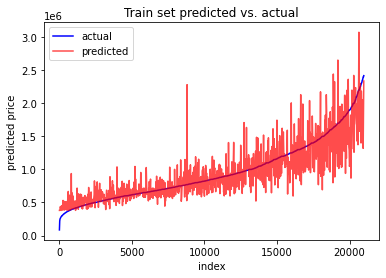

<Figure size 432x288 with 0 Axes>

In [18]:
# Make two different dfs: one for the training set and one for the testing set. 
train_pred = final_network.predict(X_train)
train_plot_df = pd.DataFrame({"Actual": np.squeeze(Y_train), "Predicted": np.squeeze(train_pred)})
train_plot_df.sort_values(by = "Actual", ascending=True, inplace=True)
train_plot_df.reset_index(drop=True, inplace=True)

test_pred = final_network.predict(X_test)
test_plot_df = pd.DataFrame({"Actual": np.squeeze(Y_test), "Predicted": np.squeeze(test_pred)})
test_plot_df.sort_values(by = "Actual", ascending=True, inplace=True)
test_plot_df.reset_index(drop=True, inplace=True)

# Plot training
plt.plot(range(0, 21000, 21), train_plot_df["Actual"][range(0, 21000, 21)], c = "blue", label = "actual")
plt.plot(range(0, 21000, 21), train_plot_df["Predicted"][range(0, 21000, 21)], c = "red", 
         label = "predicted", alpha = 0.7)
plt.xlabel("")
plt.ylabel("predicted price")
plt.xlabel("index")
plt.title("Train set predicted vs. actual")
plt.legend(loc="upper left")
plt.show()
# plt.savefig("train_performance.png")


<br>
<center><b>Figure 3:</b> Final model performance on the training set </center>

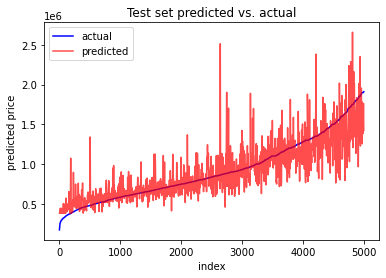

<Figure size 432x288 with 0 Axes>

In [19]:
# Plot testing. 
plt.plot(range(0, 5000, 5), test_plot_df["Actual"][range(0, 5000, 5)], c = "blue", label = "actual")
plt.plot(range(0, 5000, 5), test_plot_df["Predicted"][range(0, 5000, 5)], c = "red", 
         label = "predicted", alpha = 0.7)
plt.xlabel("")
plt.ylabel("predicted price")
plt.xlabel("index")
plt.title("Test set predicted vs. actual")
plt.legend(loc="upper left")
plt.show()
# plt.savefig("test_performance.png")

<br>
<center><b>Figure 4:</b> Final model performance on the testing set </center>

## Table of Final Results

| Model | MAE Train Loss | MAE Test Loss 
| --- | --- | --- |
| Average Price | 449500 | 456321|
| Simple Model | 280723 | 288779|
| Overfit Model | 170737 | 193264|
| Final Model | 200119 | 208717|



<br>
<center><b>Table 2:</b> Table of all train/test model performance </center>

# Conclusions

The assignment proved to be more difficult than expected, as a truly archetypal example of overfitting was never achieved and the process of making sure all details were right for for all of the different training runs (and avoiding information leaks) was quite difficult. As the old saying goes, "programming is the art of a thousand details."

One lesson to take away from this assignment is the importance of feature engineering. Part of the final network’s underperformance can probably be attributed to the fact that it was very hard to get useful geographic data from the dataset (location, location, location…). There were also very important questions of feature engineering and feature inclusion that did not have any obvious answers, and there is a lot of potential for ruining a project before any modeling actually happens just by choosing features badly. 

Another important lesson I was reminded of was the sheer complexity of hyperparameter optimization. Selecting from among just 16 hyperparameters and doing validation took many minutes, even with a top-of-the-line graphics card. In real-life, “try all possibilities” (the “responsible” thing to do) is almost never practical, and data scientists have to be judicious with the ways their spend time and decide what areas are worthy of investigation and experimentation. It introduces an import element of intuition into the workflow of machine learning that cannot be easily automated away. 

In the future, one better approach than deep learning might be a high-dimensional version of KNN with both temporal and chronological data, assuming the appropriate data can found. Another possible approach be an ensemble model of simple regressors or simpler neural networks, each trained on different feature subsets. 


# Code Attribution

All code in this notebook was my own. No code was taken from the module notebooks.